***

# **STA 221 Project Code**

***

## EDA

In [2]:
# packages

import time
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

# For Wordcloud
import wordcloud

# from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image


import plotly.express as px

In [3]:
tweets = pd.read_csv("Tweets.csv")

In [4]:
tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Graphs

In [5]:
# Company Logo color (or at least one of them) is mapped to each Airline respetively.
color_discrete_map = {
    "American": "#00a9e0",
    "United": "#005DAA",
    "Southwest": "#F9B612",
    "Delta": "#c8102e",
    "US Airways": "#bdc1c4",
    "Virgin America": "#5b056a"
}

# Plotting number of tweets per each sentiment per each airline
px.histogram(
    data_frame=tweets,
    x="airline_sentiment",
    color="airline",
    title="Sentiment Labels of Tweets by Airlines",
    labels={"airline_sentiment": "Sentiment of Tweet"},
    color_discrete_map=color_discrete_map,
)

In [7]:
# Retweets are very 0 inflated
px.histogram(data_frame=tweets,
    x="retweet_count")

In [12]:
# Looking at Reason per airline for all negative reviews
px.histogram(
    data_frame=tweets,
    x="negativereason",
    color="airline",
    title="Reason for Negative Tweets by Airline",
    labels={"negativereason": "Reason for Negative Tweet"},
    color_discrete_map=color_discrete_map,
)

### WordCloud

In [6]:
# Get one list
tweet_list = tweets["text"].tolist()

# Combine all tweets into a single string
all_tweets = " ".join(tweet_list)

# Load the plane image
plane_mask = np.array(Image.open("plane_image2.jpg"))

# color_list = np.array(['#b5d6e0',  '#ffef7a', '#f7c16a', '#ff6b3e', '#27214e'])

# Define a list of words to exclude
# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(
    [
        "the",
        "and",
        "to",
        "of",
        "a",
        "in",
        "for",
        "on",
        "is",
        "with",
        "that",
        "by",
        "this",
        "it",
        "as",
        "are",
        "be",
        "was",
        "from",
        "at",
        "will",
        "your",
        "but",
        "http",
        "you",
    ]
)

# Create a WordCloud object
# wordcloud_im = WordCloud(stopwords=stopwords, background_color='white', mask=plane_mask, color_func=color_list, width=1000, height=1000, max_words=125).generate(all_tweets)

# Plot the WordCloud image
# plt.figure(figsize=(10, 10), facecolor=None)
# plt.imshow(wordcloud_im)
# plt.axis("off")
# plt.tight_layout(pad=0)


# Save or display the image
# plt.savefig('tweet_wordcloud.png')
# plt.show()

# Lets do this by Sentiment, since this doesnt tell us much

NameError: name 'STOPWORDS' is not defined

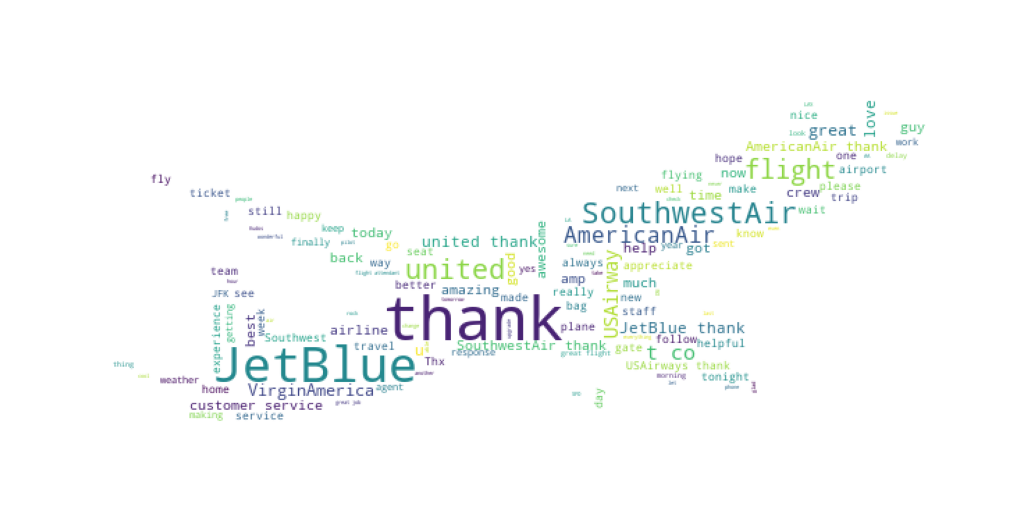

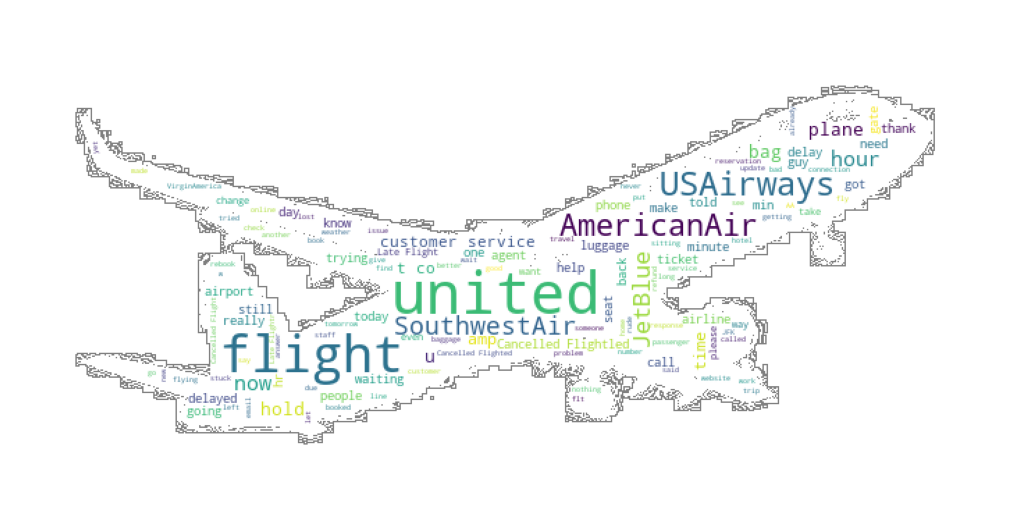

In [ ]:
tweet_list_pos = tweets.loc[tweets["airline_sentiment"] == "positive", "text"]

all_tweets_pos = " ".join(tweet_list_pos)

# Create a WordCloud object
wordcloud_im_pos = wordcloud.WordCloud(
    stopwords=stopwords,
    background_color="white",
    mask=plane_mask,
    width=1000,
    height=1000,
    max_words=125,
).generate(all_tweets_pos)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_pos)
plt.axis("off")
plt.tight_layout(pad=0)


tweet_list_neg = tweets.loc[tweets["airline_sentiment"] == "negative", "text"]

all_tweets_neg = " ".join(tweet_list_neg)

# Create a WordCloud object
wordcloud_im_neg = wordcloud.WordCloud(
    stopwords=stopwords,
    background_color="white",  # "#ccebfb",
    contour_color="grey",
    contour_width=0.01,
    mask=plane_mask,
    # width=1000,
    # height=1000,
    max_words=125,
).generate(all_tweets_neg)

# Plot the WordCloud image
plt.figure(figsize=(10, 10), facecolor=None)
plt.imshow(wordcloud_im_neg)
plt.axis("off")
plt.tight_layout(pad=0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create feature vectors
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True)

train_vectors = vectorizer.fit_transform(tweets["text"])

In [ ]:
# SVM | https://medium.com/scrapehero/sentiment-analysis-using-svm-338d418e3ff1

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel="linear")
t0 = time.time()
classifier_linear.fit(train_vectors, tweets["airline_sentiment"])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1 - t0
time_linear_predict = t2 - t1
# results
print(
    "Training time: %fs; Prediction time: %fs"
    % (time_linear_train, time_linear_predict)
)
report = classification_report(testData["Label"], prediction_linear, output_dict=True)
print("positive: ", report["pos"])
print("negative: ", report["neg"])

NameError: name 'test_vectors' is not defined

In [ ]:
# https://www.educative.io/answers/how-to-use-svm-for-sentiment-analysis

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report


text = tweets["text"].values
labels = tweets["airline_sentiment"].values

text_train, text_test, labels_train, labels_test = train_test_split(
    text, labels, test_size=0.2, random_state=42
)

vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(text_train)
features_test = vectorizer.transform(text_test)

svm = SVC(kernel="linear")
svm.fit(features_train, labels_train)

predictions = svm.predict(features_test)
new_text = [
    "I hate Devin Booker",
    "Thai Canteen has awful service.",
    "The new Titebond glue is amazing.",
]
new_features = vectorizer.transform(new_text)
new_predictions = svm.predict(new_features)
print(new_predictions)

# Step 7: Generate the classification report to evaluate the model
print(classification_report(labels_test, predictions))

['negative' 'neutral' 'positive']
              precision    recall  f1-score   support

    negative       0.86      0.87      0.86      1889
     neutral       0.58      0.56      0.57       580
    positive       0.70      0.71      0.71       459

    accuracy                           0.78      2928
   macro avg       0.71      0.71      0.71      2928
weighted avg       0.78      0.78      0.78      2928



In [ ]:
# https://www.kaggle.com/code/lbronchal/sentiment-analysis-with-svm

data_clean = tweets[tweets["airline_sentiment_confidence"] > 0.65]
data_clean["sentiment"] = data_clean["airline_sentiment"].apply(
    lambda x: 1 if x == "negative" else 0
)

data_clean["text_clean"] = data_clean["text"].apply(
    lambda x: BeautifulSoup(x, "lxml").text
)